# HONIR UP impol 2023

2023/10/12

In [1]:
!pwd

/home/akitaya/d5


In [2]:
cd honir_impol

/mnt/data5/users/akitaya/honir_impol


In [3]:
import os
from datetime import datetime

In [4]:
datetime.strptime('2023-10-23', "%Y-%m-%d")

datetime.datetime(2023, 10, 23, 0, 0)

In [5]:
def get_flat_fn(obsdate):
    flat_dir = '/home/akitaya/d5/honir_impol/flat/'
    #if datetime.strptime(obsdate, "%Y-%m-%d") < datetime.strptime('2023-02-03', "%Y-%m-%d"):
    #    return(os.path.join(flat_dir, "2023-01-22/flat_opt_ImPol_R_partial.fits"))
    if datetime.strptime(obsdate, "%Y-%m-%d") < datetime.strptime('2023-05-01', "%Y-%m-%d"):
        return(os.path.join(flat_dir, "2023-02-17/flat_opt_ImPol_R_partial.fits"))
    else:
        return(os.path.join(flat_dir, "2023-05-12/flat_opt_ImPol_R_partial.fits"))

## from kottamia_tools

In [6]:
import numpy as np
from astropy.io import fits

In [7]:
def show_all_headers(fn):
    """ Show all fits header information.
    """
    with fits.open(fn) as hdul:
        for key in hdul[0].header:
            print(key, hdul[0].header[key])

In [8]:
def select_images_by_header(fns, cond_dict, logic='or'):
    """ Select filenames by fits header values.
    :param fns: file name list to be seached.
    :param cond_dict: Dictionary of a pair of header_key and value.
    :return: file name list.
    """
    fns_result = []
    for fn in fns:
        with fits.open(fn) as hdul:
            if logic == 'or':
                for key in cond_dict:
                    if hdul[0].header[key] == cond_dict[key]:
                        fns_result.append(fn)
            else:
                flag = True
                for key in cond_dict:
                    if hdul[0].header[key] != cond_dict[key]:
                        flag = False
                if flag:
                    fns_result.append(fn)
    return fns_result

In [26]:
def bias_subtraction(fn: str, fn_bias: str, overwrite=False, subext='_bs'):
    """ Bias subtraction.
    """
    with fits.open(fn) as hdul_img:
        with fits.open(fn_bias) as hdul_bias:
            fn_splt = os.path.splitext(fn)
            fn_new = fn_splt[0] + subext + fn_splt[1]
            hdul_img[0].data -= hdul_bias[0].data
            # Comments
            hdul_img[0].header['history'] = f'Bias subtraction: {fn} - {fn_bias} = {fn_new}'
            hdul_img.writeto(fn_new, overwrite=overwrite)
            return fn_new
    return None


def flat_fielding(fn: str, fn_flat: str, overwrite=False, subext='_fl'):
    """ Flat fielding.
    """
    with fits.open(fn) as hdul_img:
        with fits.open(fn_flat) as hdul_flat:
            fn_splt = os.path.splitext(fn)
            fn_new = fn_splt[0] + subext + fn_splt[1]
            hdul_img[0].data /= hdul_flat[0].data
            # Comments
            hdul_img[0].header['history'] = f'Flat fielding: {fn} / {fn_flat} = {fn_new}'
            hdul_img.writeto(fn_new, overwrite=overwrite)
            return fn_new
    return None

In [10]:
def imgs_combine(fns, fn_out=None, overwrite=True):
    """ Combine fits images.
    median mode.
    """
    imgs = []
    for fn in fns:
        with fits.open(fn) as hdul:
            imgs.append(hdul[0].data)
            print(fn)
    if len(imgs) < 1:
        sys.stderr.write('No images found.\n')
        sys.exit(1)
    imgs_ndarray = np.stack(imgs)
    del(imgs)
    imgs_comb = np.median(imgs_ndarray, axis=0)
    hdul[0].data = imgs_comb
    hdul[0].header['history'] = f'Combined: {str(fns)}'
    hdul[0].header['history'] = f'Combined file name: {fn}'
    if fn_out:
        hdul.writeto(fn_out, overwrite=overwrite)
    print(f'Write to {fn_out}')
    del(imgs_ndarray)
    return(hdul)


In [11]:
!ls

2023-01-22  20230116  20230204	20230402  20230821  20231002
2023-02-17  20230130  20230224	20230421  20230822  flat
2023-05-12  20230201  20230228	20230806  20230826  honir_impol_reduction.ipynb


In [12]:
cd 20230116

/mnt/data5/users/akitaya/honir_impol/20230116


In [13]:
import glob

In [14]:
fns = glob.glob('*.bs.fits')
fns.sort()

Get flat file path.

In [15]:
flat_date_str = fits.getheader(fns[0])['DATE-OBS']
flat_fn = get_flat_fn(flat_date_str)
print(flat_date_str, flat_fn)

2023-01-16 /home/akitaya/d5/honir_impol/flat/2023-02-17/flat_opt_ImPol_R_partial.fits


In [16]:
os.path.isfile(flat_fn)

True

In [17]:
fns_bias = select_images_by_header(fns, {'DATA-TYP': 'BIAS'})

In [18]:
hdul = imgs_combine(fns_bias, fn_out='bias_comb.fits')

HN0325182opt00.bs.fits
HN0325183opt00.bs.fits
HN0325184opt00.bs.fits
HN0325185opt00.bs.fits
HN0325186opt00.bs.fits
HN0325187opt00.bs.fits
HN0325188opt00.bs.fits
HN0325189opt00.bs.fits
HN0325190opt00.bs.fits
HN0325191opt00.bs.fits
Write to bias_comb.fits


In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

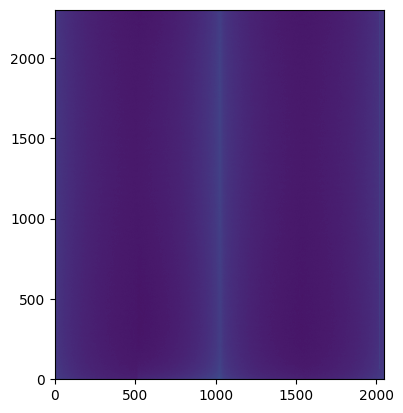

In [20]:
plt.ylim([0,2300])
plt.imshow(hdul[0].data)

In [21]:
fns_obj = select_images_by_header(fns, {'DATA-TYP': 'STANDARD'})

In [22]:
fn_bias = 'bias_comb.fits'
fns_bsub = []
for fn in fns_obj:
    fns_bsub.append(bias_subtraction(fn, fn_bias, overwrite=True))

In [23]:
fns_bsub

['HN0325056opt00.bs_bs.fits',
 'HN0325057opt00.bs_bs.fits',
 'HN0325058opt00.bs_bs.fits',
 'HN0325059opt00.bs_bs.fits',
 'HN0325060opt00.bs_bs.fits',
 'HN0325061opt00.bs_bs.fits',
 'HN0325062opt00.bs_bs.fits',
 'HN0325063opt00.bs_bs.fits',
 'HN0325064opt00.bs_bs.fits',
 'HN0325065opt00.bs_bs.fits',
 'HN0325066opt00.bs_bs.fits',
 'HN0325067opt00.bs_bs.fits']

In [25]:
flat_fn

'/home/akitaya/d5/honir_impol/flat/2023-02-17/flat_opt_ImPol_R_partial.fits'

In [29]:
fns_flat = []
for fn in fns_bsub:
    fns_flat.append(flat_fielding(fn, flat_fn, overwrite=True))

In [30]:
fns_flat

['HN0325056opt00.bs_bs_fl.fits',
 'HN0325057opt00.bs_bs_fl.fits',
 'HN0325058opt00.bs_bs_fl.fits',
 'HN0325059opt00.bs_bs_fl.fits',
 'HN0325060opt00.bs_bs_fl.fits',
 'HN0325061opt00.bs_bs_fl.fits',
 'HN0325062opt00.bs_bs_fl.fits',
 'HN0325063opt00.bs_bs_fl.fits',
 'HN0325064opt00.bs_bs_fl.fits',
 'HN0325065opt00.bs_bs_fl.fits',
 'HN0325066opt00.bs_bs_fl.fits',
 'HN0325067opt00.bs_bs_fl.fits']

In [33]:
plt.imshow(fits.getdata(fns_flat[0]), vmin=0, vmax=200)

In [34]:
!pwd

/mnt/data5/users/akitaya/honir_impol/20230116


In [41]:
cd ..

/mnt/data5/users/akitaya/honir_impol


In [42]:
!pwd

/mnt/data5/users/akitaya/honir_impol


In [43]:
obs_date_strs = glob.glob('2023????')
obs_date_strs.sort()

In [44]:
obs_date_strs

['20230116',
 '20230130',
 '20230201',
 '20230204',
 '20230224',
 '20230228',
 '20230402',
 '20230421',
 '20230806',
 '20230821',
 '20230822',
 '20230826',
 '20231002']

In [82]:
def preproc(obs_date_str, overwrite=True):
    if not os.path.isdir(obs_date_str):
        return False
    os.chdir(obs_date_str)
    
    fns = glob.glob('*opt00.bs.fits')
    fns.sort()

    # Bias combination.
    fn_bias = 'bias_comb.fits'
    fns_bias = select_images_by_header(fns, {'DATA-TYP': 'BIAS'})
    hdul = imgs_combine(fns_bias, fn_out=fn_bias)

    # Bias subtraction.
    fns_obj = select_images_by_header(fns, {'DATA-TYP': 'STANDARD'})
    fns_bsub = []
    for fn in fns_obj:
        fns_bsub.append(bias_subtraction(fn, fn_bias, overwrite=True))

    # Flat fielding.
    flat_date_str = fits.getheader(fns[0])['DATE-OBS']
    flat_fn = get_flat_fn(flat_date_str)
    fns_flat = []
    for fn in fns_bsub:
        fns_flat.append(flat_fielding(fn, flat_fn, overwrite=True))

    os.chdir('..')
    
    return fns_flat

In [83]:
for obsdate in obs_date_strs:
    print(f'Preproc {obsdate}')
    preproc(obsdate)

Preproc 20230116
HN0325182opt00.bs.fits
HN0325183opt00.bs.fits
HN0325184opt00.bs.fits
HN0325185opt00.bs.fits
HN0325186opt00.bs.fits
HN0325187opt00.bs.fits
HN0325188opt00.bs.fits
HN0325189opt00.bs.fits
HN0325190opt00.bs.fits
HN0325191opt00.bs.fits
Write to bias_comb.fits
Preproc 20230130
HN0325182opt00.bs.fits
HN0325183opt00.bs.fits
HN0325184opt00.bs.fits
HN0325185opt00.bs.fits
HN0325186opt00.bs.fits
HN0325187opt00.bs.fits
HN0325188opt00.bs.fits
HN0325189opt00.bs.fits
HN0325190opt00.bs.fits
HN0325191opt00.bs.fits
HN0327002opt00.bs.fits
HN0327003opt00.bs.fits
HN0327004opt00.bs.fits
HN0327005opt00.bs.fits
HN0327006opt00.bs.fits
HN0327007opt00.bs.fits
HN0327008opt00.bs.fits
HN0327009opt00.bs.fits
HN0327010opt00.bs.fits
HN0327011opt00.bs.fits
Write to bias_comb.fits


KeyboardInterrupt: 

In [ ]:
!ls

In [ ]:
!ls 20230826

In [56]:
def easy_imshow(fn):
    imgdata = fits.getdata(fn)
    plt.imshow(imgdata, vmin=0, vmax = np.median(imgdata)*3.0)

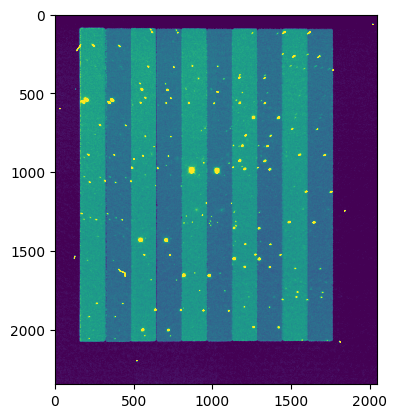

In [57]:
easy_imshow('20230826/HN0345349opt00.bs_bs_fl.fits')

https://docs.google.com/spreadsheets/d/1OMKOIUWQNX4EdlF7uKXkK_aiUqXyYWqTDyMejkQYgoE/edit#gid=0

# 2023/10/13

10/02のbias画像に天体画像が紛れている。

In [59]:
!pwd

/mnt/data5/users/akitaya/honir_impol


In [93]:
fns_1002 = glob.glob('20231002/*opt00.bs.fits')
fns_1002.sort()

In [94]:
fns_1002_dtbias = select_images_by_header(fns_1002, {'DATA-TYP': 'BIAS'})

In [95]:
for fn in fns_1002_dtbias:
    with fits.open(fn) as hdul:
        imgdata = hdul[0].data
        print(f'{fn}, stddev: {np.std(imgdata)}, median: {np.median(imgdata)}, max: {np.max(imgdata)}')

20231002/HN0347111opt00.bs.fits, stddev: 37.116966247558594, median: 16.60976791381836, max: 28994.12890625
20231002/HN0347112opt00.bs.fits, stddev: 37.116966247558594, median: 16.60976791381836, max: 28994.12890625
20231002/HN0347113opt00.bs.fits, stddev: 37.116966247558594, median: 16.60976791381836, max: 28994.12890625
20231002/HN0347114opt00.bs.fits, stddev: 37.116966247558594, median: 16.60976791381836, max: 28994.12890625
20231002/HN0347115opt00.bs.fits, stddev: 37.116966247558594, median: 16.60976791381836, max: 28994.12890625
20231002/HN0347116opt00.bs.fits, stddev: 37.116966247558594, median: 16.60976791381836, max: 28994.12890625
20231002/HN0347117opt00.bs.fits, stddev: 37.116966247558594, median: 16.60976791381836, max: 28994.12890625
20231002/HN0347118opt00.bs.fits, stddev: 37.116966247558594, median: 16.60976791381836, max: 28994.12890625
20231002/HN0347119opt00.bs.fits, stddev: 37.116966247558594, median: 16.60976791381836, max: 28994.12890625
20231002/HN0347120opt00.bs.f

In [96]:
fits.getheader(fns_1002[0])

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2048                                                  
NAXIS2  =                 2348                                                  
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
DETID   = '0       '           / Detector ID                                    
GMTS-MSA= '1696246983'         / time()                                         
GMT-MSA = '2023/10/02 11:43:03' / y/m/d h:m:s                                   
LST-MSA = '2023/10/02 20:43:03' / y/m/d h:m:s                                   
SPV     = 'read_y2350'         / spv_com pattern name                           
OBSERVER= 'Kawabata,Hori,Mar

In [97]:
fns_1002_dtbias[:10]

['20231002/HN0347111opt00.bs.fits',
 '20231002/HN0347112opt00.bs.fits',
 '20231002/HN0347113opt00.bs.fits',
 '20231002/HN0347114opt00.bs.fits',
 '20231002/HN0347115opt00.bs.fits',
 '20231002/HN0347116opt00.bs.fits',
 '20231002/HN0347117opt00.bs.fits',
 '20231002/HN0347118opt00.bs.fits',
 '20231002/HN0347119opt00.bs.fits',
 '20231002/HN0347120opt00.bs.fits']

異常画像は削除。

In [98]:
for fn in fns_1002_dtbias[:10]:
    os.remove(fn)
    print(f'remove {fn}')

remove 20231002/HN0347111opt00.bs.fits
remove 20231002/HN0347112opt00.bs.fits
remove 20231002/HN0347113opt00.bs.fits
remove 20231002/HN0347114opt00.bs.fits
remove 20231002/HN0347115opt00.bs.fits
remove 20231002/HN0347116opt00.bs.fits
remove 20231002/HN0347117opt00.bs.fits
remove 20231002/HN0347118opt00.bs.fits
remove 20231002/HN0347119opt00.bs.fits
remove 20231002/HN0347120opt00.bs.fits


In [101]:
fns_1002_dtbias = select_images_by_header(fns_1002, {'DATA-TYP': 'BIAS'})

In [102]:
fns_1002_dtbias

['20231002/HN0347121opt00.bs.fits',
 '20231002/HN0347122opt00.bs.fits',
 '20231002/HN0347123opt00.bs.fits',
 '20231002/HN0347124opt00.bs.fits',
 '20231002/HN0347125opt00.bs.fits',
 '20231002/HN0347126opt00.bs.fits',
 '20231002/HN0347127opt00.bs.fits',
 '20231002/HN0347128opt00.bs.fits',
 '20231002/HN0347129opt00.bs.fits',
 '20231002/HN0347130opt00.bs.fits']

In [ ]:
preproc('20231002')

HN0347121opt00.bs.fits
HN0347122opt00.bs.fits
HN0347123opt00.bs.fits
HN0347124opt00.bs.fits
HN0347125opt00.bs.fits
HN0347126opt00.bs.fits
HN0347127opt00.bs.fits
HN0347128opt00.bs.fits
HN0347129opt00.bs.fits
HN0347130opt00.bs.fits
Write to bias_comb.fits


## object check

In [112]:
datestrs = sorted(glob.glob('2023????'))

In [114]:
from astropy.table import Table

In [138]:
objtable = Table(names=('dateobs', 'objname', 'ra', 'dec', 'equinox'), dtype=(['U1']*4+['f4']))

In [140]:
for datestr in datestrs:
    fns = glob.glob(os.path.join(datestr, 'HN*fl.fits'))
    fns_obj = select_images_by_header(fns, {'DATA-TYP': 'STANDARD'})
    with fits.open(fns_obj[0]) as hdul:
        hdr = hdul[0].header
        objname = hdr['OBJECT']
        ra = hdr['RA']
        dec = hdr['DEC']
        eq = hdr['EQUINOX']
        dateobs = hdr['DATE-OBS']
        print([dateobs, objname, ra, dec, eq])
        objtable.add_row([dateobs, objname, ra, dec, eq])

['2023-01-16', 'G191B2B', '05:05:30.60', '+52:49:54.0', 2000.0]
['2023-01-16', 'G191B2B', '05:05:30.60', '+52:49:54.0', 2000.0]
['2023-02-01', 'HD18803', '03:02:25.90', '+26:36:34.0', 2000.0]
['2023-02-04', 'HD18803', '03:02:25.90', '+26:36:34.0', 2000.0]
['2023-02-24', 'HD65583', '08:00:32.20', '+29:12:43.9', 2000.0]
['2023-02-28', 'HD154892', '17:07:41.30', '+15:12:38.0', 2000.0]
['2023-04-02', 'G191B2B', '05:05:30.60', '+52:49:54.0', 2000.0]
['2023-04-21', 'HD65583', '08:00:32.20', '+29:12:43.9', 2000.0]
['2023-08-06', 'HD212311', '22:21:58.50', '+56:31:51.9', 2000.0]
['2023-08-21', 'BD28', '21:51:11.10', '+28:51:52.0', 2000.0]
['2023-08-22', 'BD28d', '21:51:11.10', '+28:51:52.0', 2000.0]
['2023-08-26', 'BD28', '21:51:11.10', '+28:51:52.0', 2000.0]
['2023-10-02', 'BD28', '21:51:11.10', '+28:51:52.0', 2000.0]


In [141]:
objtable.show_in_notebook()

In [142]:
!pip install astroquery

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 19.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 2.5 MB/s eta 0:00:00a 0:00:01
  Obtaining dependency information for keyring>=4.0 from https://files.pythonhosted.org/packages/0e/8f/5772801169cf62e8232721034f91f81e33b0cfa6e51d3bf6ff65c503af2a/keyring-24.2.0-py3-none-any.whl.metadata
  Obtaining dependency information for pyvo>=1.1 from https://files.pythonhosted.org/packages/6f/d3/ce8d1ec673464caf53cf4f85d195f73ed1adc729a4acce22ac434fc64c79/pyvo-1.4.2-py3-none-any.whl.metadata
  Obtaining dependency information for jaraco.classes from https://files.pythonhosted.org/packages/c7/6b/1bc8fa93ea85146e08f0e0883bc579b7c7328364ed7df90b1628dcb36e10/jaraco.classes-3.3.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 1.7 MB/s eta 0:00:00
  Obtaining dependency information for cryptography>=2.0 from https://files.pythonhosted.org/packages/eb/4b/f86cc66c632cf0948

In [146]:
from astroquery.simbad import Simbad

In [148]:
import astropy.units as u
from astropy.coordinates import SkyCoord

In [151]:
coord = SkyCoord(objtable[0]['ra'], objtable[0]['dec'], unit=(u.hour, u.deg))

In [155]:
results = Simbad.query_region(coord, radius=1.0*u.arcmin)

In [159]:
from astropy.table import vstack

In [164]:
simbad_results = []
for obj in objtable:
    coord = SkyCoord(obj['ra'], obj['dec'], unit=(u.hour, u.deg))
    result = Simbad.query_region(coord, radius=1.0*u.arcmin)
    simbad_results.append(result[0])
all_results = vstack(simbad_results)
del(simbad_results)

In [166]:
all_results.show_in_notebook()

In [167]:
from astroquery.skyview import SkyView

In [173]:
imgs = SkyView.get_images(coord, survey=['DSS'])

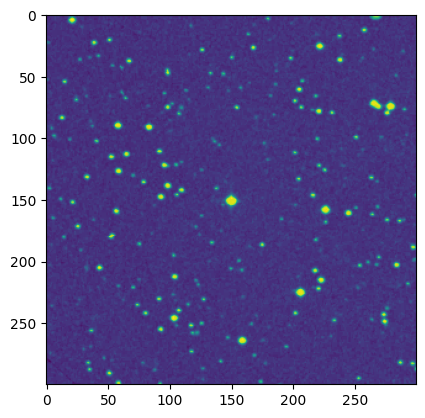

In [180]:
plt.imshow(imgs[0][0].data)